# Fact or Fake: News Analysis

## Data Mining 334
## Alex Laughlin, Xandre Clementsmith, Terence Carey

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import sklearn
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import re
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import FunctionTransformer

## Dataframe Creation and Manipulation

In [2]:
#pull in data

#read in politifact
df_p_real = pd.read_csv('politifact_real.csv')
df_p_fake = pd.read_csv('politifact_fake.csv')

df_p_real['true/false'] = True

df_p_fake['true/false'] = False

#read in gossipcop data
df_g_real = pd.read_csv('gossipcop_real.csv')
df_g_fake = pd.read_csv('gossipcop_fake.csv')

df_g_real['true/false'] = True

df_g_fake['true/false'] = False

In [3]:
#Join tables together
sets = "p"
if sets == "p":
    frames = [df_p_real, df_p_fake]
elif sets == "g":
    frames = [df_g_real, df_g_fake]
elif sets == "b":
    frames = [df_p_real, df_p_fake, df_g_real, df_g_fake]
df = pd.concat(frames)
df = df[['news_url', 'title','true/false']]
print(df.head(5))
df.shape

                                            news_url  \
0                          http://www.nfib-sbet.org/   
1  http://www.cq.com/doc/newsmakertranscripts-494...   
2  https://web.archive.org/web/20080204072132/htt...   
3  https://web.archive.org/web/20110811143753/htt...   
4  https://web.archive.org/web/20070820164107/htt...   

                                               title  true/false  
0        National Federation of Independent Business        True  
1                        comments in Fayetteville NC        True  
2  Romney makes pitch, hoping to close deal : Ele...        True  
3  Democratic Leaders Say House Democrats Are Uni...        True  
4    Budget of the United States Government, FY 2008        True  


(1056, 3)

In [4]:
# How many values of each truth value (label)
df['true/false'].value_counts()

True     624
False    432
Name: true/false, dtype: int64

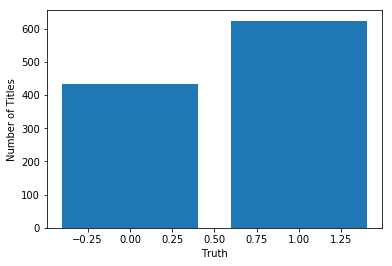

In [5]:
True_False_count=df.groupby('true/false').count()
plt.bar(True_False_count.index.values, True_False_count['title'])
plt.xlabel('Truth')
plt.ylabel('Number of Titles')
plt.show()

## Tokenization

In [6]:
def pipelinize(function, active=True):
    def list_comprehend_a_function(list_or_series,active=True):
        if active:
            return [function(i) for i in list_or_series]
        else:
            return list_or_series
    return FunctionTransformer(list_comprehend_a_function,
                              validate=False, kw_args={'active':active})

def tokenize(text):

    tokenizer = nltk.RegexpTokenizer(r"\w{3,}")
    
    
    #remove special characters
    #data['title'] = data.apply(lambda row: re.sub('[^A-Za-z ]{3,}', '', str(row['title'])), axis =1)
    title = re.sub('[^A-Za-z ]{3,}', '', text)
    
    #tokenize words from title
    tokenized_sents = tokenizer.tokenize(title)
    #tokenized_sents = title.apply(lambda row: tokenizer.tokenize(row['title']))
    
    #remove stop words from tokenized titles
    tokens_without_stopwords = [item for item in tokenized_sents if item not in stop_words]
    #tokens_without_stopwords = tokenized_sents.apply(lambda x: [item for item in x if item not in stop_words])
    
    return tokens_without_stopwords
    
    

def stem(text):
    stemmer = SnowballStemmer("english")
    
    #stem tokenized words without stopwords
    #tokens_stemmed=tokens_without_stopwords.apply(lambda x : [stemmer.stem(y) for y in x])
    tokens_stemmed=[stemmer.stem(y) for y in text]
    return tokens_stemmed
        
def lemmatize(text):
    
    #lemmatize tokenized words without stopwords
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens_lemmatized = [lemmatizer.lemmatize(y) for y in text]
    
    return tokens_lemmatized

#parse source URL and strip down to base form 
from urllib.parse import urlparse
import urllib as urllib
df['parsedURL'] = df.apply(lambda row: urlparse(str(row['news_url'])).netloc, axis=1)
df['extension'] = df.apply(lambda row: str(row['parsedURL'])[-3:], axis = 1)

In [7]:
from sklearn.pipeline import Pipeline


stemEstimators = [('tokenizer', pipelinize(tokenize)), ('stemmer', pipelinize(stem))]
lemEstimators = [('tokenizer', pipelinize(tokenize)), ('lemmatizer', pipelinize(lemmatize))]

stemPipe = Pipeline(stemEstimators)
lemPipe = Pipeline(lemEstimators)

In [8]:
df['tokens_stemmed'] = stemPipe.transform(df['title'])
df['tokens_lemmatized'] = lemPipe.transform(df['title'])
df.head(10)

,news_url,title,true/false,parsedURL,extension,tokens_stemmed,tokens_lemmatized
0,http://www.nfib-sbet.org/,National Federation of Independent Business,True,www.nfib-sbet.org,org,"[nation, feder, independ, busi]","[National, Federation, Independent, Business]"
1,http://www.cq.com/doc/newsmakertranscripts-494...,comments in Fayetteville NC,True,www.cq.com,com,"[comment, fayettevill]","[comment, Fayetteville]"
2,https://web.archive.org/web/20080204072132/htt...,"Romney makes pitch, hoping to close deal : Ele...",True,web.archive.org,org,"[romney, make, pitch, hope, close, deal, elect...","[Romney, make, pitch, hoping, close, deal, Ele..."
3,https://web.archive.org/web/20110811143753/htt...,Democratic Leaders Say House Democrats Are Uni...,True,web.archive.org,org,"[democrat, leader, say, hous, democrat, are, u...","[Democratic, Leaders, Say, House, Democrats, A..."
4,https://web.archive.org/web/20070820164107/htt...,"Budget of the United States Government, FY 2008",True,web.archive.org,org,"[budget, unit, state, govern]","[Budget, United, States, Government]"
5,http://www.politifact.com/truth-o-meter/statem...,Donald Trump exaggerates when he says China ha...,True,www.politifact.com,com,"[donald, trump, exagger, say, china, total, co...","[Donald, Trump, exaggerates, say, China, total..."
6,https://www.law.cornell.edu/constitution/amend...,25th Amendment,True,www.law.cornell.edu,edu,"[25th, amend]","[25th, Amendment]"
7,http://americaneedsmitt.com/blog/2011/11/10/mi...,子供たちのコト。私のコト。,True,americaneedsmitt.com,com,[],[]
8,https://web.archive.org/web/20090913221204/htt...,Briefing by White House Press Secretary Robert...,True,web.archive.org,org,"[brief, white, hous, press, secretari, robert,...","[Briefing, White, House, Press, Secretary, Rob..."
9,https://web.archive.org/web/20080623122709/htt...,A Solar Grand Plan: Scientific American,True,web.archive.org,org,"[solar, grand, plan, scientif, american]","[Solar, Grand, Plan, Scientific, American]"


## IDF

In [9]:
# MODULAR COMPONENT:
# select token_type for machine learning algorithms
# tokens_stemmed performs best
token_type = 'tokens_stemmed'

In [10]:
#create corpus from lemmatized tokens as numpy array
corpus = df[token_type].to_numpy()

#create dictionary
DF = {}

#write unique words to dictionary
for i in range(len(corpus)):
    tokens = corpus[i]
    for w in tokens:
        try:
            DF[w].add(i)
        except:
            DF[w] = {i}
            
#get word frequency
for i in DF:
    DF[i] = len(DF[i])
# print(DF)

In [11]:
#create column of strings from lemmatized tokens
df['tfidfprep']=[" ".join(x) for x in df[token_type].values]

#initialize tfidf vectorizer
tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.7)

#call vectorizer on text columns
tfidf_numbers=tfidf_vectorizer.fit_transform(df['tfidfprep']) 

#convert vectorizer data to dataframe
df1 = pd.DataFrame(tfidf_numbers.toarray(), columns=tfidf_vectorizer.get_feature_names())
print("df1 SHAPE = "+str(df1.shape))
print(df1.columns)
#sources is the one hot encoding of the parsedURL
extensions = pd.get_dummies(df['extension'])
print("EXTENSIONS SHAPE = "+str(extensions.shape))
print(extensions.columns)

#drop duplicates?
#df1.drop_duplicates(inplace=True)
#sources.drop_duplicates(inplace=True)

#join vectorizer data and one hot encoded sources columns
#numberDF = pd.concat([df1, sources], axis = 1)
numberDF = extensions.join(df1, lsuffix = '_left', rsuffix = '_right')


labels=df[["true/false"]]

#create train and test sets
x_train, x_test, y_train, y_test= train_test_split(numberDF, labels, test_size=0.2, stratify=df['true/false'], random_state=7)

print(numberDF.head)


df1 SHAPE = (1056, 2517)
Index(['10k', '22m', '25th', '27ave', '2kilo', '2nd', '3rd', '3year',
       'abandon', 'abc',
       ...
       'wwii', 'year', 'yearbook', 'yellow', 'york', 'young', 'younger',
       'youngest', 'youtub', 'zakaria'],
      dtype='object', length=2517)
EXTENSIONS SHAPE = (1056, 23)
Index(['', '.be', '.co', '.is', '.me', '.pw', '.ru', '.tk', '.uk', '.us',
       'com', 'edu', 'ews', 'gov', 'ife', 'ite', 'ive', 'lub', 'mil', 'net',
       'nfo', 'one', 'org'],
      dtype='object')
<bound method NDFrame.head of         .be  .co  .is  .me  .pw  .ru  .tk  .uk  .us  ...  wwii  year  \
0    0    0    0    0    0    0    0    0    0    0  ...   0.0   0.0   
0    1    0    0    0    0    0    0    0    0    0  ...   0.0   0.0   
1    0    0    0    0    0    0    0    0    0    0  ...   0.0   0.0   
1    1    0    0    0    0    0    0    0    0    0  ...   0.0   0.0   
2    0    0    0    0    0    0    0    0    0    0  ...   0.0   0.0   
..  ..  ...  ...  ...  ...

## Machine Learning

### Logistic Regression (Baseline)

In [12]:
lr = Pipeline([('classifier', LogisticRegression(random_state=0))])

lr.fit(x_train, y_train.values.ravel())

print("Training Data")
lr_y_pred = lr.predict(x_train)
#print score
print(classification_report(y_train,lr_y_pred))
print(confusion_matrix(y_train,lr_y_pred))

lr_y_pred = lr.predict(x_test)

print("Test Data")
print(classification_report(y_test,lr_y_pred))
print(confusion_matrix(y_test,lr_y_pred))

Training Data
              precision    recall  f1-score   support

       False       0.95      0.66      0.77       345
        True       0.80      0.97      0.88       499

    accuracy                           0.84       844
   macro avg       0.87      0.81      0.83       844
weighted avg       0.86      0.84      0.84       844

[[226 119]
 [ 13 486]]
Test Data
              precision    recall  f1-score   support

       False       0.93      0.49      0.65        87
        True       0.73      0.98      0.84       125

    accuracy                           0.78       212
   macro avg       0.83      0.74      0.74       212
weighted avg       0.82      0.78      0.76       212

[[ 43  44]
 [  3 122]]


### Decision Tree

In [13]:
dt = Pipeline([('classifier', DecisionTreeClassifier(random_state=0))])

dt.fit(x_train, y_train.values.ravel())

print("Training Data")
dt_y_pred = dt.predict(x_train)
#print score
print(classification_report(y_train,dt_y_pred))
print(confusion_matrix(y_train,dt_y_pred))

dt_y_pred = dt.predict(x_test)

print("Test Data")
print(classification_report(y_test,dt_y_pred))
print(confusion_matrix(y_test,dt_y_pred))

Training Data
              precision    recall  f1-score   support

       False       0.91      1.00      0.95       345
        True       1.00      0.93      0.96       499

    accuracy                           0.96       844
   macro avg       0.96      0.97      0.96       844
weighted avg       0.96      0.96      0.96       844

[[345   0]
 [ 34 465]]
Test Data
              precision    recall  f1-score   support

       False       0.67      0.77      0.72        87
        True       0.82      0.74      0.78       125

    accuracy                           0.75       212
   macro avg       0.75      0.75      0.75       212
weighted avg       0.76      0.75      0.75       212

[[67 20]
 [33 92]]


### RandomForest

In [14]:
rf = Pipeline([('classifier', RandomForestClassifier(random_state=0, min_samples_split = 5))])

rf.fit(x_train, y_train.values.ravel())

print("Training Data")
rf_y_pred = rf.predict(x_train)
#print score
print(classification_report(y_train,rf_y_pred))
print(confusion_matrix(y_train,rf_y_pred))

rf_y_pred = rf.predict(x_test)

print("Test Data")
print(classification_report(y_test,rf_y_pred))
print(confusion_matrix(y_test,rf_y_pred))

Training Data
              precision    recall  f1-score   support

       False       0.94      0.95      0.95       345
        True       0.97      0.96      0.96       499

    accuracy                           0.96       844
   macro avg       0.96      0.96      0.96       844
weighted avg       0.96      0.96      0.96       844

[[329  16]
 [ 20 479]]
Test Data
              precision    recall  f1-score   support

       False       0.82      0.62      0.71        87
        True       0.77      0.90      0.83       125

    accuracy                           0.79       212
   macro avg       0.80      0.76      0.77       212
weighted avg       0.79      0.79      0.78       212

[[ 54  33]
 [ 12 113]]


### Passive Aggresive Classifier

In [15]:
#instantiate passive aggresive classifier
pac = Pipeline([('classifier', PassiveAggressiveClassifier(max_iter=100, random_state=0))])


pac.fit(x_train, y_train.values.ravel())

print("Training Data")
pac_y_pred = pac.predict(x_train)
#print score
print(classification_report(y_train,pac_y_pred))
print(confusion_matrix(y_train,pac_y_pred))

pac_y_pred = pac.predict(x_test)

print("Test Data")
print(classification_report(y_test,pac_y_pred))
print(confusion_matrix(y_test,pac_y_pred))

Training Data
              precision    recall  f1-score   support

       False       0.89      0.97      0.93       345
        True       0.98      0.92      0.95       499

    accuracy                           0.94       844
   macro avg       0.94      0.95      0.94       844
weighted avg       0.95      0.94      0.94       844

[[336   9]
 [ 40 459]]
Test Data
              precision    recall  f1-score   support

       False       0.77      0.91      0.84        87
        True       0.93      0.82      0.87       125

    accuracy                           0.85       212
   macro avg       0.85      0.86      0.85       212
weighted avg       0.86      0.85      0.85       212

[[ 79   8]
 [ 23 102]]


### Passive Aggressive Classifier with lemmatization

In [18]:
#create column of strings from lemmatized tokens
df['tfidfprep']=[" ".join(x) for x in df['tokens_lemmatized'].values]
labels=df[["true/false"]]

#initialize tfidf vectorizer
tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.7)

#call vectorizer on text columns
tfidf_numbers=tfidf_vectorizer.fit_transform(df['tfidfprep']) 

#convert vectorizer data to dataframe
df1 = pd.DataFrame(tfidf_numbers.toarray(), columns=tfidf_vectorizer.get_feature_names())
print("df1 SHAPE = "+str(df1.shape))
print(df1.columns)
#sources is the one hot encoding of the parsedURL
extensions = pd.get_dummies(df['extension'])
print("EXTENSIONS SHAPE = "+str(extensions.shape))
print(extensions.columns)

#drop duplicates?
#df1.drop_duplicates(inplace=True)
#sources.drop_duplicates(inplace=True)

#join vectorizer data and one hot encoded sources columns
#numberDF = pd.concat([df1, sources], axis = 1)
numberDF = extensions.join(df1, lsuffix = '_left', rsuffix = '_right')


labels=df[["true/false"]]


df1 SHAPE = (1056, 3016)
Index(['10k', '22m', '25th', '27ave', '2kilos', '2nd', '3rd', '3year',
       'abandon', 'abc',
       ...
       'year', 'yearbook', 'years', 'yellow', 'york', 'young', 'younger',
       'youngest', 'youtube', 'zakaria'],
      dtype='object', length=3016)
EXTENSIONS SHAPE = (1056, 23)
Index(['', '.be', '.co', '.is', '.me', '.pw', '.ru', '.tk', '.uk', '.us',
       'com', 'edu', 'ews', 'gov', 'ife', 'ite', 'ive', 'lub', 'mil', 'net',
       'nfo', 'one', 'org'],
      dtype='object')


In [19]:
pac.fit(x_train, y_train.values.ravel())

print("Training Data")
pac_y_pred = pac.predict(x_train)
#print score
print(classification_report(y_train,pac_y_pred))
print(confusion_matrix(y_train,pac_y_pred))

pac_y_pred = pac.predict(x_test)

print("Test Data")
print(classification_report(y_test,pac_y_pred))
print(confusion_matrix(y_test,pac_y_pred))

Training Data
              precision    recall  f1-score   support

       False       0.88      0.98      0.93       345
        True       0.98      0.91      0.94       499

    accuracy                           0.94       844
   macro avg       0.93      0.94      0.93       844
weighted avg       0.94      0.94      0.94       844

[[338   7]
 [ 47 452]]
Test Data
              precision    recall  f1-score   support

       False       0.73      0.91      0.81        87
        True       0.92      0.77      0.84       125

    accuracy                           0.83       212
   macro avg       0.83      0.84      0.82       212
weighted avg       0.84      0.83      0.83       212

[[79  8]
 [29 96]]


## Conclusion
The Passive Aggressor classifier has the highest accuracy at 85%. It additionally also has the best precision and recall scores, so we consider it to be the best model for prediction of the validity of headlines. We also compare the accuracy of the PAC and stemmed words with the accuracy of the PAC and lemmatized words and see that stemmed wins by 2%. For precision and recall as well, stemmed words are better than lemmatized by 2%.